In [1]:
#CONEXIÓN A SNOWFLAKE
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Conectar a Snowflake
conn = snowflake.connector.connect(
    account='ABPWBUP-LSB46287',
    user='SERVICE',
    password='pofnIk-6kikhe-bokbyj',
    warehouse='COMPUTE_WH',
    database='INSTACART_DB',
    schema='RAW',
    role='ACCOUNTADMIN'
)

# Función para obtener datos de Snowflake
def obtener_datos(query):
    cur = conn.cursor()
    cur.execute(query)
    data = cur.fetchall()
    columns = [desc[0] for desc in cur.description]
    cur.close()
    return pd.DataFrame(data, columns=columns)

# Obtener lista de tablas en el esquema RAW
tablas_query = "SHOW TABLES IN SCHEMA RAW"
tablas_df = obtener_datos(tablas_query)
tablas = tablas_df['name'].tolist()


In [39]:
#DIMENSIÓN DE LOS DATOS 
print("Las dimesiones de los datos son:")

# Obtener número de filas y columnas para cada tabla
for tabla in tablas:
    # Obtener número de filas
    filas_query = f"SELECT COUNT(*) FROM RAW.{tabla}"
    filas_df = obtener_datos(filas_query)
    num_filas = filas_df.iloc[0, 0]  # Obtiene el valor directamente

    # Obtener número de columnas
    columnas_query = f"SELECT column_name FROM information_schema.columns WHERE table_schema = 'RAW' AND table_name = '{tabla.upper()}'"
    columnas_df = obtener_datos(columnas_query)
    num_columnas = len(columnas_df)

    print(f"Tabla {tabla}: {num_filas} filas, {num_columnas} columnas")


Las dimesiones de los datos son:
Tabla AISLES: 134 filas, 2 columnas
Tabla DEPARTMENTS: 21 filas, 2 columnas
Tabla INSTACART_ORDERS: 478967 filas, 7 columnas
Tabla ORDER_PRODUCTS: 4545007 filas, 4 columnas
Tabla PRODUCTS: 49694 filas, 4 columnas


In [42]:
#Análisis de las tablas AISLES y DEPARTMENTS
# Función para analizar estadística descriptiva y calidad de datos
def analizar_tabla(tabla, id_col, name_col):
    # 1. Obtener valores únicos (SE IMPRIMEN PRIMERO)
    conteo_id_query = f'SELECT COUNT(DISTINCT "{id_col}") FROM RAW."{tabla}"'
    valores_unicos_id = obtener_datos(conteo_id_query).iloc[0, 0]

    conteo_name_query = f'SELECT COUNT(DISTINCT "{name_col}") FROM RAW."{tabla}"'
    valores_unicos_name = obtener_datos(conteo_name_query).iloc[0, 0]

    # 2. Problemas de calidad
    calidad_query = f'SELECT * FROM RAW."{tabla}"'
    calidad_df = obtener_datos(calidad_query)

    total_missing = calidad_df.isnull().sum().sum()
    duplicados = calidad_df.duplicated().sum()
    tipos_datos = calidad_df.dtypes.astype(str)

    # 3. Crear un DataFrame con los resultados
    resultados = pd.DataFrame({
        "Métrica": [
            "Cantidad de IDs únicos",
            "Cantidad de nombres únicos",
            "Datos ausentes",
            "Registros duplicados",
            "Tipos de datos"
        ],
        tabla: [
            valores_unicos_id,
            valores_unicos_name,
            total_missing,
            duplicados,
            ", ".join([f"{col}: {tipo}" for col, tipo in tipos_datos.items()])
        ]
    })
    
    return resultados

# Analizar ambas tablas y mostrar juntas
aisles_df = analizar_tabla("AISLES", "aisle_id", "aisle")
departments_df = analizar_tabla("DEPARTMENTS", "department_id", "department")

# Unir los DataFrames para comparar en columnas
resultados_final = aisles_df.merge(departments_df, on="Métrica", how="outer")

# Mostrar resultados en Pandas en consola sin tabulate ni ace_tools
print("\n🔹 Análisis Exploratorio y Problemas de Calidad de las tablas: AISLES & DEPARTMENTS\n")
print(resultados_final.to_string(index=False))



🔹 Análisis Exploratorio y Problemas de Calidad de las tablas: AISLES & DEPARTMENTS

                   Métrica                         AISLES                              DEPARTMENTS
    Cantidad de IDs únicos                            134                                       21
Cantidad de nombres únicos                            134                                       21
            Datos ausentes                              0                                        0
      Registros duplicados                              0                                        0
            Tipos de datos aisle_id: int64, aisle: object department_id: int64, department: object


In [6]:
# Análisis de la tabla PRODUCTS
def analizar_productos():
    print("\n🔹 Análisis Exploratorio y Problemas de Calidad de la tabla: PRODUCTS")

    # Obtener todos los datos para análisis de calidad
    calidad_query = 'SELECT * FROM RAW."PRODUCTS"'
    calidad_df = obtener_datos(calidad_query)

    # Identificar valores ausentes correctamente
    calidad_df["product_name"] = calidad_df["product_name"].replace([None], pd.NA)
    
    # Normalizar product_name excluyendo valores ausentes
    calidad_df["product_name_normalizado"] = calidad_df["product_name"].dropna().str.lower().str.strip()

    # Cantidad total y valores únicos en product_name
    total_productos = len(calidad_df)
    valores_unicos_product = calidad_df["product_name_normalizado"].nunique()
    print(f"\nCantidad total de productos: {total_productos}")
    print(f"Valores únicos en product_name: {valores_unicos_product}")

     # Contar valores ausentes en product_name
    missing_values = calidad_df["product_name"].isna().sum()
    if missing_values > 0:
        print(f"Total de valores ausentes en product_name: {missing_values}")
    
    # Verificar si los valores ausentes en product_name tienen duplicados en aisle_id y department_id
    df_nulos = calidad_df[calidad_df["product_name"].isna()]
    if not df_nulos.empty:
        # Verificar si todos los valores ausentes tienen el mismo aisle_id y department_id
        df_nulos_check = df_nulos[["aisle_id", "department_id"]].nunique()
        if df_nulos_check.max() == 1:
            aisle_id = df_nulos["aisle_id"].iloc[0]
            department_id = df_nulos["department_id"].iloc[0]
            print(f"✔️ Todos los registros con product_name ausente tienen los mismos aisle_id ({aisle_id}) y department_id ({department_id}).")
        else:
            nulos_identicos = (df_nulos_check.max() == 1).sum()
            nulos_no_identicos = (df_nulos_check.max() > 1).sum()
            print(f"✔️ Registros con product_name ausente y los mismos aisle_id y department_id: {nulos_identicos}")
            print(f"⚠️ Registros con product_name ausente y diferencias en aisle_id o department_id: {nulos_no_identicos}")
    else:
        print("✔️ No hay registros con product_name ausente.")

    # Registros duplicados en product_name (ignorando espacios y mayúsculas/minúsculas)
    df_no_nulos = calidad_df.dropna(subset=["product_name"])
    duplicados = df_no_nulos.duplicated(subset=["product_name_normalizado"], keep=False).sum()
    if duplicados > 0:
        print(f"Registros duplicados en product_name: {duplicados}")

    # Verificar si los registros duplicados son idénticos en aisle_id y department_id
    df_duplicados = df_no_nulos[df_no_nulos.duplicated(subset=["product_name_normalizado"], keep=False)]
    if not df_duplicados.empty:
        df_duplicados_check = df_duplicados.groupby("product_name_normalizado")[["aisle_id", "department_id"]].nunique()
        if df_duplicados_check.max().max() == 1:
            print("✔️ Todos los registros duplicados tienen los mismos aisle_id y department_id.")
        else:
            duplicados_identicos = (df_duplicados_check.max(axis=1) == 1).sum()
            duplicados_no_identicos = (df_duplicados_check.max(axis=1) > 1).sum()
            print(f"✔️ Registros duplicados con los mismos aisle_id y department_id: {duplicados_identicos}")
            print(f"⚠️ Registros duplicados con diferencias en aisle_id o department_id: {duplicados_no_identicos}")

    # Inconsistencias en tipos de datos
    print("\nTipos de datos:")
    print(calidad_df.dtypes)
    
# Ejecutar análisis de la tabla PRODUCTS
analizar_productos()





🔹 Análisis Exploratorio y Problemas de Calidad de la tabla: PRODUCTS

Cantidad total de productos: 49694
Valores únicos en product_name: 48332
Total de valores ausentes en product_name: 1258
✔️ Todos los registros con product_name ausente tienen los mismos aisle_id (100) y department_id (21).
Registros duplicados en product_name: 207
✔️ Registros duplicados con los mismos aisle_id y department_id: 86
⚠️ Registros duplicados con diferencias en aisle_id o department_id: 17

Tipos de datos:
product_id                   int64
product_name                object
aisle_id                     int64
department_id                int64
product_name_normalizado    object
dtype: object


In [64]:
# Obtener registros duplicados con diferencias en aisle_id o department_id desde Snowflake

query_duplicados_no_identicos = '''
    SELECT *
    FROM RAW."PRODUCTS"
    WHERE LOWER(TRIM("product_name")) IN (
        SELECT LOWER(TRIM("product_name"))
        FROM RAW."PRODUCTS"
        WHERE "product_name" IS NOT NULL AND TRIM("product_name") <> ''
        GROUP BY LOWER(TRIM("product_name"))
        HAVING COUNT(DISTINCT "aisle_id") > 1 OR COUNT(DISTINCT "department_id") > 1
    )
    ORDER BY LOWER(TRIM("product_name"))
'''

df_duplicados_no_identicos = obtener_datos(query_duplicados_no_identicos)

if not df_duplicados_no_identicos.empty:
    print("\n⚠️ Registros duplicados con diferencias en aisle_id o department_id:")
    print(df_duplicados_no_identicos.to_string(index=False))  # Imprime sin índice para mejor visualización
else:
    print("\n✅ No se encontraron registros duplicados con diferencias en aisle_id o department_id.")



⚠️ Registros duplicados con diferencias en aisle_id o department_id:
 product_id                           product_name  aisle_id  department_id
      44079                         Blanc de Noirs       134              5
      11164                         Blanc De Noirs        62              5
      31293                 Chicken With Rice Soup        13             20
      10748                 Chicken with Rice Soup        69             15
      29912                Chopped Garlic In Water        81             15
      18313                Chopped Garlic in Water       123              4
      30675               Edamame Soybeans in Pods       116              1
      21750               Edamame Soybeans In Pods        83              4
       2038       Green Tea with Ginseng and Honey        94              7
      19814       Green Tea With Ginseng And Honey        94              7
       5456       Green Tea With Ginseng and Honey        96             20
      38950       


🔹 Análisis Exploratorio y Problemas de Calidad de la tabla: INSTACART_ORDERS

Resumen de Estadísticas:
                       Mínimo Máximo   Promedio  Moda    std dev
order_number              1.0  100.0  17.157808   1.0  17.704688
order_hour_of_day         0.0   23.0  13.446676  10.0   4.224986
days_since_prior_order    0.0   30.0  11.101751  30.0   9.189975
order_dow                                         0.0           

Total de órdenes: 478967
Conteo de valores únicos en order_id: 478952
Total de registros duplicados en order_id: 30
✔️ Todos los registros duplicados de order_id también tienen los mismos valores en las demás columnas.

Conteo de valores ausentes:
days_since_prior_order    28819
dtype: int64

Tipos de datos:
id                          int64
order_id                    int64
user_id                     int64
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object


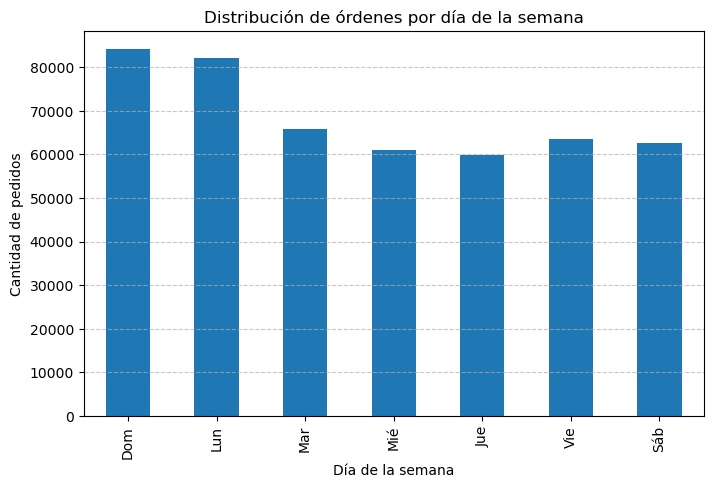

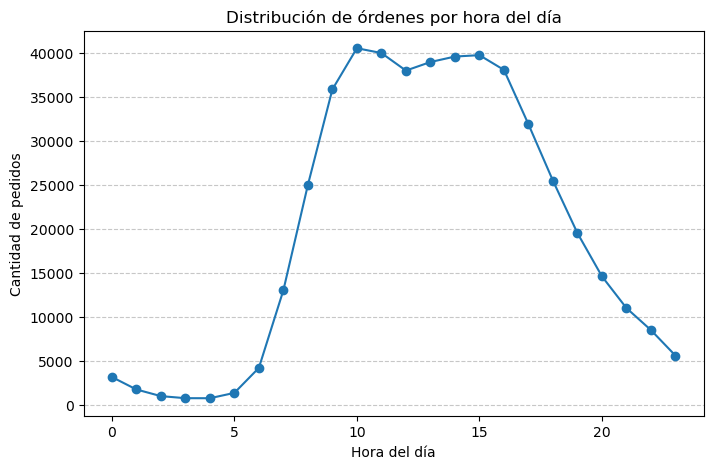

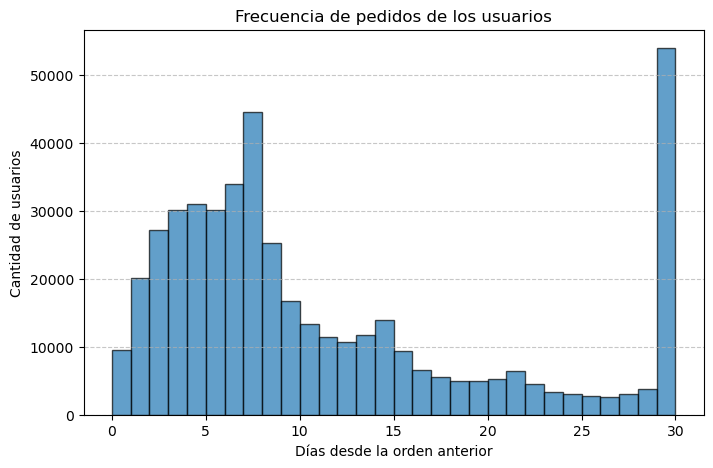

In [100]:
# Análisis de la tabla INSTACART_ORDERS
def analizar_instacart_orders():
    print("\n🔹 Análisis Exploratorio y Problemas de Calidad de la tabla: INSTACART_ORDERS")
    
    # Obtener todos los datos
    query = 'SELECT * FROM RAW."INSTACART_ORDERS"'
    df = obtener_datos(query)
    
    # Convertir columnas numéricas a tipo adecuado
    numeric_cols = ['order_number', 'order_hour_of_day', 'days_since_prior_order']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # Crear una tabla con estadísticas
    stats = pd.DataFrame({
        'Mínimo': df[numeric_cols].min(),
        'Máximo': df[numeric_cols].max(),
        'Promedio': df[numeric_cols].mean(),
        'Moda': df[numeric_cols].mode().iloc[0],
        'std dev': df[numeric_cols].std()
    })
    
    # Agregar order_dow con solo la moda
    stats.loc['order_dow'] = ['', '', '', df['order_dow'].mode().iloc[0], '']
    
    print("\nResumen de Estadísticas:")
    print(stats)  # Imprime todas las filas del resumen estadístico
    
    # Total de órdenes
    print("\nTotal de órdenes:", len(df))
    
    # Conteo de valores únicos en order_id
    print("Conteo de valores únicos en order_id:", df['order_id'].nunique())
    
    # Identificar registros duplicados (excluyendo la columna 'id')
    cols_to_check = ['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
    duplicate_orders = df[df.duplicated(subset=cols_to_check, keep=False)]
    
    print("Total de registros duplicados en order_id:", len(duplicate_orders))
    
    # Verificar si los registros duplicados son idénticos en las columnas relevantes
    if not duplicate_orders.empty:
        duplicate_orders_check = duplicate_orders.groupby("order_id")[cols_to_check].nunique()
        if duplicate_orders_check.max().max() == 1:
            print("✔️ Todos los registros duplicados de order_id también tienen los mismos valores en las demás columnas.")
        else:
            exact_duplicates = (duplicate_orders_check.max(axis=1) == 1).sum()
            non_exact_duplicates = (duplicate_orders_check.max(axis=1) > 1).sum()
            print(f"✔️ Registros duplicados completamente idénticos: {exact_duplicates}")
            print(f"⚠️ Registros duplicados con diferencias en otras columnas: {non_exact_duplicates}")
    
    # Conteo de valores ausentes
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]  # Filtrar solo los que tienen valores ausentes
    if not missing_values.empty:
        print("\nConteo de valores ausentes:")
        print(missing_values)
    
    # Tipos de datos
    print("\nTipos de datos:")
    print(df.dtypes)

    # Gráfico: Distribución de órdenes por día de la semana
    plt.figure(figsize=(8,5))
    df['order_dow'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('Día de la semana')
    plt.ylabel('Cantidad de pedidos')
    plt.title('Distribución de órdenes por día de la semana')
    plt.xticks(ticks=range(7), labels=['Dom','Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Gráfico: Distribución de órdenes por hora del día
    plt.figure(figsize=(8,5))
    df['order_hour_of_day'].value_counts().sort_index().plot(kind='line', marker='o')
    plt.xlabel('Hora del día')
    plt.ylabel('Cantidad de pedidos')
    plt.title('Distribución de órdenes por hora del día')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Gráfico: Frecuencia de pedidos de los usuarios
    plt.figure(figsize=(8,5))
    df['days_since_prior_order'].dropna().plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel('Días desde la orden anterior')
    plt.ylabel('Cantidad de usuarios')
    plt.title('Frecuencia de pedidos de los usuarios')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Ejecutar análisis de la tabla INSTACART_ORDERS
analizar_instacart_orders()



🔹 Análisis Exploratorio y Problemas de Calidad de la tabla: ORDER_PRODUCTS

Cantidad de productos que se añadieron en primer lugar al carrito: 450046
Cantidad de productos que se añadieron en último lugar al carrito: 75
Total de `reordered` con valor 0: 1861169
Total de `reordered` con valor 1: 2683838

Total de órdenes: 4545007
Total de combinaciones únicas `order_id` y `product_id`: 4545007

Valores ausentes:
add_to_cart_order    836
dtype: int64

Tipos de datos:
order_id               int64
product_id             int64
add_to_cart_order    float64
reordered              int64
dtype: object


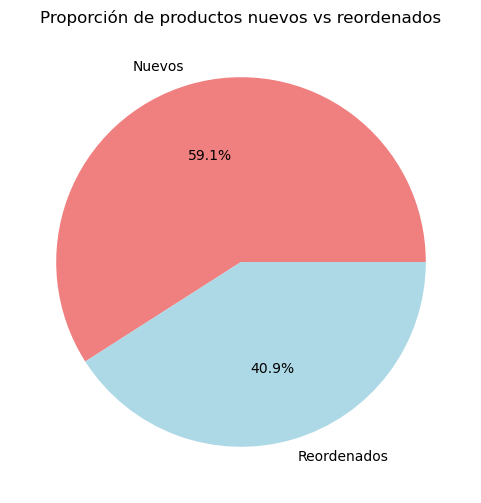

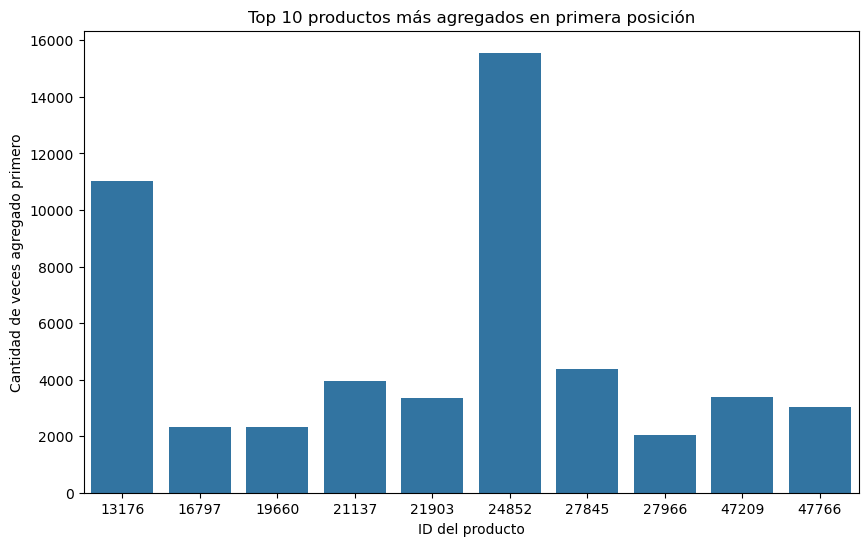

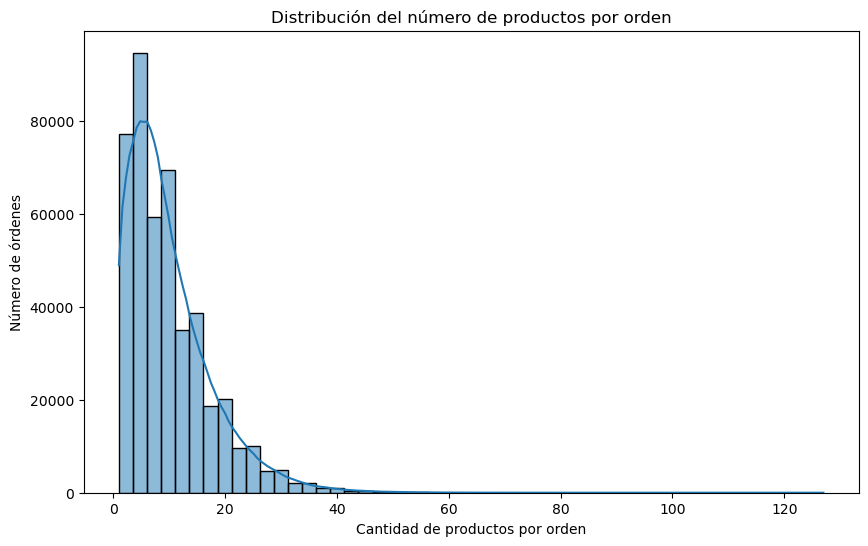

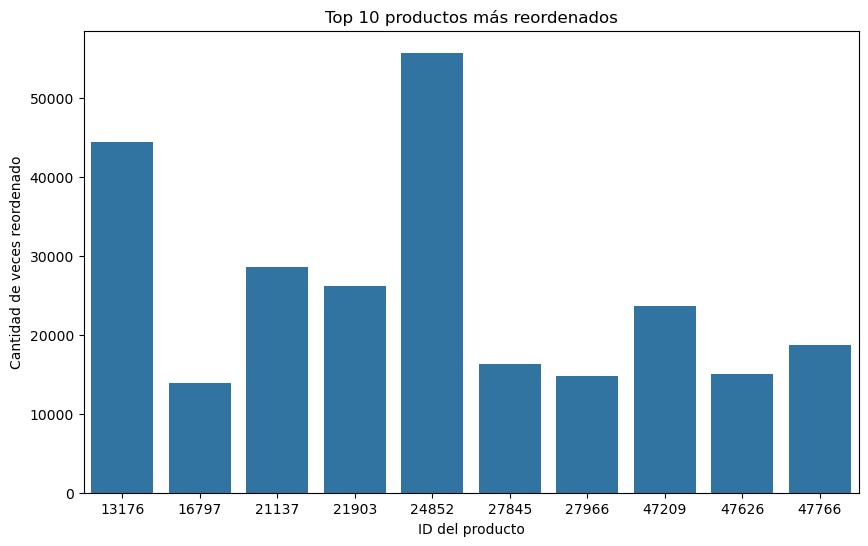

In [103]:
# Análisis de la tabla ORDER_PRODUCTS
def analizar_order_products():
    print("\n🔹 Análisis Exploratorio y Problemas de Calidad de la tabla: ORDER_PRODUCTS")

    # Obtener todos los datos
    query = 'SELECT * FROM RAW."ORDER_PRODUCTS"'
    df = obtener_datos(query)

    # Convertir columnas numéricas a tipo adecuado
    df[['add_to_cart_order', 'product_id', 'reordered']] = df[['add_to_cart_order', 'product_id', 'reordered']].apply(pd.to_numeric, errors='coerce')

    # Encontrar el mínimo, máximo y moda de add_to_cart_order y la cantidad de productos que pertenecen a cada uno
    min_add_to_cart = df['add_to_cart_order'].min()
    max_add_to_cart = df['add_to_cart_order'].max()
    mode_add_to_cart = df['add_to_cart_order'].mode().iloc[0]

    count_min = df[df['add_to_cart_order'] == min_add_to_cart].shape[0]
    count_max = df[df['add_to_cart_order'] == max_add_to_cart].shape[0]
    count_mode = df[df['add_to_cart_order'] == mode_add_to_cart].shape[0]

    # Contar reordered con valor 0 y 1
    reordered_0 = df[df['reordered'] == 0].shape[0]
    reordered_1 = df[df['reordered'] == 1].shape[0]

    # Contar total de order_id
    total_orders = df['order_id'].nunique()

    # Contar combinaciones únicas de order_id y product_id
    unique_order_product = df[['order_id', 'product_id']].drop_duplicates().shape[0]

    # Buscar valores ausentes en todas las columnas
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]  # Filtrar solo los que tienen valores ausentes

    # Mostrar resultados
    print(f"\nCantidad de productos que se añadieron en primer lugar al carrito: {count_min}")
    print(f"Cantidad de productos que se añadieron en último lugar al carrito: {count_max}")
    print(f"Total de `reordered` con valor 0: {reordered_0}")
    print(f"Total de `reordered` con valor 1: {reordered_1}")

    # Total de órdenes
    print("\nTotal de órdenes:", len(df))
    print(f"Total de combinaciones únicas `order_id` y `product_id`: {unique_order_product}")

    if not missing_values.empty:
        print("\nValores ausentes:")
        print(missing_values)
    else:
        print("\n✔️ No hay valores ausentes en la tabla.")

    # Tipos de datos
    print("\nTipos de datos:")
    print(df.dtypes)

    # Gráfico: Distribución de productos añadidos al carrito
    # Gráfico de pastel - Comparación entre productos nuevos y reordenados
    plt.figure(figsize=(6, 6))
    df['reordered'].value_counts().plot.pie(autopct='%1.1f%%', labels=["Nuevos", "Reordenados"], colors=['lightcoral', 'lightblue'])
    plt.title("Proporción de productos nuevos vs reordenados")
    plt.ylabel("")
    plt.show()
    
    # Gráfico de barras - Top 10 productos más agregados en primera posición
    top_first_added = df[df['add_to_cart_order'] == 1]['product_id'].value_counts().nlargest(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_first_added.index, y=top_first_added.values)
    plt.xlabel("ID del producto")
    plt.ylabel("Cantidad de veces agregado primero")
    plt.title("Top 10 productos más agregados en primera posición")
    plt.show()
    
    # Histograma - Distribución del número de productos por orden
    order_sizes = df.groupby("order_id")["product_id"].count()
    plt.figure(figsize=(10, 6))
    sns.histplot(order_sizes, bins=50, kde=True)
    plt.xlabel("Cantidad de productos por orden")
    plt.ylabel("Número de órdenes")
    plt.title("Distribución del número de productos por orden")
    plt.show()
    
    # Gráfico de barras - Top 10 productos más reordenados
    top_reordered = df[df['reordered'] == 1]['product_id'].value_counts().nlargest(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_reordered.index, y=top_reordered.values)
    plt.xlabel("ID del producto")
    plt.ylabel("Cantidad de veces reordenado")
    plt.title("Top 10 productos más reordenados")
    plt.show()
    
# Ejecutar la función
analizar_order_products()


In [4]:
def contar_nulos_por_order_id():
    print("\n🔹 Contando valores nulos de add_to_cart_order por order_id")

    # Obtener todos los datos
    query = 'SELECT * FROM RAW."ORDER_PRODUCTS"'
    df = obtener_datos(query)

    # Convertir columnas numéricas a tipo adecuado
    df[['add_to_cart_order', 'product_id', 'reordered']] = df[['add_to_cart_order', 'product_id', 'reordered']].apply(pd.to_numeric, errors='coerce')

    # Filtrar valores nulos en add_to_cart_order
    df_nulos = df[df['add_to_cart_order'].isna()]

    # Contar la cantidad de nulos por order_id
    count_nulos = df_nulos.groupby('order_id').size().reset_index(name='cantidad_nulos')

    return count_nulos

contar_nulos_por_order_id()


🔹 Contando valores nulos de add_to_cart_order por order_id


,order_id,cantidad_nulos
0,9310,1
1,61355,63
2,102236,31
3,129627,5
4,165801,6
...,...,...
65,2999801,6
66,3125735,22
67,3308010,51
68,3347453,7


In [5]:
def contar_nulos_por_product_id():
    print("\n🔹 Contando valores nulos de add_to_cart_order por product_id")

    # Obtener todos los datos
    query = 'SELECT * FROM RAW."ORDER_PRODUCTS"'
    df = obtener_datos(query)

    # Convertir columnas numéricas a tipo adecuado
    df[['add_to_cart_order', 'product_id', 'reordered']] = df[['add_to_cart_order', 'product_id', 'reordered']].apply(pd.to_numeric, errors='coerce')

    # Filtrar valores nulos en add_to_cart_order
    df_nulos = df[df['add_to_cart_order'].isna()]

    # Contar la cantidad de nulos por product_id
    count_nulos = df_nulos.groupby('product_id').size().reset_index(name='cantidad_nulos')

    return count_nulos

contar_nulos_por_product_id()


🔹 Contando valores nulos de add_to_cart_order por product_id


,product_id,cantidad_nulos
0,10,1
1,34,2
2,63,1
3,79,1
4,160,1
...,...,...
715,49325,1
716,49474,1
717,49621,1
718,49644,1


Análisis de Calidad de Datos en la Base de Datos de Instacart

1. Tablas AISLES y DEPARTMENTS
Se confirma que las tablas AISLES y DEPARTMENTS no presentan problemas de calidad de datos. Ambas contienen IDs y nombres únicos, sin valores ausentes ni registros duplicados. Además, los tipos de datos son los adecuados (int64 para los identificadores y object para los nombres).

2. Tabla PRODUCTS
La tabla PRODUCTS presenta los siguientes problemas:
-Valores ausentes: Hay 1,258 productos sin nombre (product_name), lo que dificulta su identificación. Sin embargo, todos estos registros comparten los mismos valores de aisle_id y department_id, que corresponden a "missing", por lo que se evidencia que estos productos ya se estan manejando internamente por la empresa. 
-Duplicados: Se identificaron 207 registros duplicados en product_name, de los cuales:
--86 registros comparten el mismo aisle_id y department_id, lo que indica que podrían ser productos repetidos en la base de datos y que requieren consolidación.
--17 registros tienen discrepancias en aisle_id o department_id, lo que sugiere una posible inconsistencia en la clasificación de los productos.

3. Tabla INSTACART_ORDERS
La tabla INSTACART_ORDERS presenta los siguientes problemas:
-Registros duplicados: Hay 30 órdenes duplicadas (15 pares), con valores idénticos en todas sus columnas, lo que indica una posible inserción redundante en la base de datos.
-Valores ausentes: Se detectaron 28,819 valores nulos en days_since_prior_order, lo que probablemente corresponde a usuarios que realizaron su primer pedido y, por lo tanto, no tienen una compra anterior registrada.
-Estadísticas relevantes:
--Moda de order_dow: El día más frecuente de compras es el domingo (0 en el dataset).
--Promedio de order_number: El número promedio de órdenes por usuario es 17.16, lo que indica una alta recurrencia de clientes.
--Distribución de order_hour_of_day: El promedio de compras se realiza alrededor de las 13:44 horas.

4. Tabla ORDER_PRODUCTS
La tabla ORDER_PRODUCTS presenta los siguientes problemas:
-Duplicados: No hay combinaciones duplicadas de order_id y product_id, lo que indica una correcta estructuración de los pedidos y sus productos asociados.
-Valores ausentes: Se detectaron 836 valores nulos en add_to_cart_order, lo que puede indicar que ciertos productos no tienen un registro preciso del orden en que fueron añadidos al carrito.
-Distribución de reordenamiento (reordered):
--1,861,169 productos fueron comprados por primera vez (reordered = 0).
--2,683,838 productos fueron reordenados (reordered = 1).
--Esto sugiere que los clientes tienden a realizar compras recurrentes, lo que es útil para estrategias de marketing y fidelización.

Plan de Transformación y Curación de Datos

1. Manejo de Valores Ausentes
-Para product_name en PRODUCTS: llenar el campo con "missing product", pues se descubrió que todos los productos sin nombre forman parte de tanto la isla como el departamente missing, lo que significa que ya están teniendo un control por parte de la compania. 
-Para days_since_prior_order en INSTACART_ORDERS: llenar el campo con el número 0, ya que representan usuarios sin órdenes previas (su primer pedido).
-Para add_to_cart_order en ORDER_PRODUCTS: llenar el campo con el número -1, pues de esta forma no se modificará la integridad de los datos. 

2. Eliminación o Consolidación de Duplicados
-En PRODUCTS:
--Unificar los 86 productos duplicados que tienen el mismo aisle_id y department_id, conservando solo un registro.
--Mantener todos los registros de las 17 parejas con discrepancias en aisle_id o department_id, pues al tener product_id únicos se trata de productos separados a pesar de tener el mismo nombre (habría que consultar con la empresa si se quiere hacer un análisis más profundo para poder distinguir porque difieren).
-En INSTACART_ORDERS: Unificar las 30 órdenes duplicadas que son completamente idénticas.

3. Conversión de Tipos de Datos y Normalización
-Convertir add_to_cart_order en ORDER_PRODUCTS de float64 a int64, eliminando los valores nulos previamente.
-Convertir days_since_prior_order en INSTACART_ORDERS de float64 a int64.
-Normalizar la columna product_name para que no varien mayúsculas o minúsculas.
-Eliminar la columna id de INSTACART_ORDERS, pues esta consiste solo de una llave primaria incremental que no aporta valor. 